## Imports

In [89]:
import os, requests, pandas as pd
from IPython.display import display, clear_output
import math
import yfinance as yf
from matplotlib import pyplot as plt
import time
import platform
from datetime import datetime

## Tradier API

In [90]:
os.environ["TRADIER_TOKEN"] = "tiEeBvbQhxYsfxEkp9CYKPnsGP4E"
TOKEN = os.environ["TRADIER_TOKEN"]
BASE = "https://api.tradier.com/"
HEADERS = { "Authorization": f"Bearer {TOKEN}", "Accept": "application/json" }

### Quotes

In [91]:
def tradier(path, params=None, verb="GET", data=None):
    url = BASE + path.lstrip("/")
    r = requests.request(verb, url, headers=HEADERS, params=params, data=data, timeout=10)
    if r.status_code != 200:
        raise RuntimeError(f"HTTP {r.status_code}: {r.text[:300]} ...")
    if "application/json" not in r.headers.get("Content-Type", ""):
        raise RuntimeError(f"Unexpected content-type: {r.headers.get('Content-Type')}:\n {r.text[:300]} ...")
    return r.json()

### Get Last Price

In [92]:
def get_last_price(symbol):
    js = tradier("v1/markets/quotes", params={"symbols": symbol})
    quotes = js["quotes"]["quote"]
    return quotes['last']

### Option Chain

In [93]:
def get_chain(symbol, expiration, option_type="call"):
    chain = tradier("v1/markets/options/chains", params={"symbol": symbol, "expiration": expiration, "greeks": True})
    return chain["options"]["option"]



#### Example

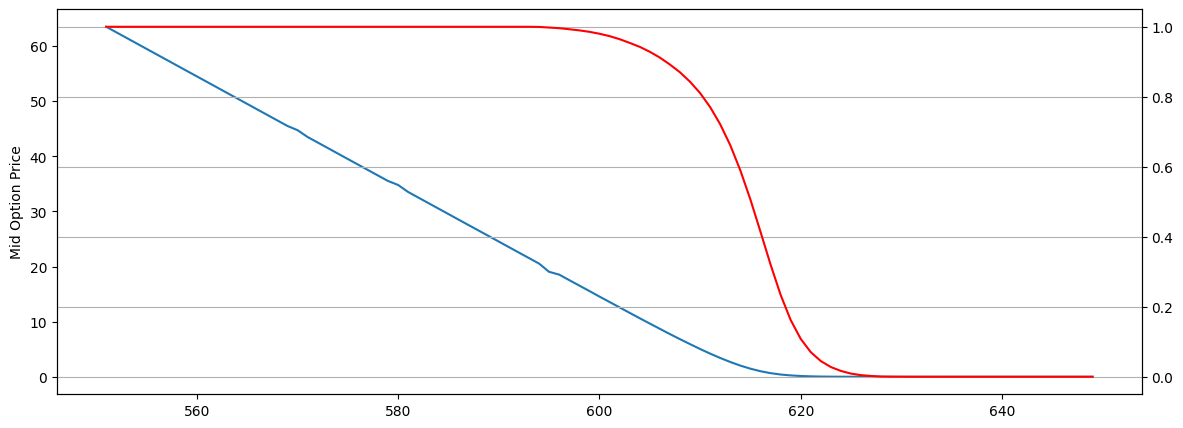

In [94]:

u_lim, l_lim = 650, 550
op_deltas = {}
op_prices = {}
for op in get_chain("SPY", "2025-06-30"):
    k = op['strike']
    mid = (op['bid'] + op['ask']) / 2
    if op['option_type'] == 'call' and k > l_lim and k < u_lim:
        op_prices[k] = mid
        op_deltas[k] = op["greeks"]["delta"]

fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(op_prices.keys(), op_prices.values(), label='Call Price')
ax1.set_ylabel("Mid Option Price")
ax2 = ax1.twinx()
ax2.plot(op_deltas.keys(), op_deltas.values(), color='r', label='Call $Delta$')
plt.xlabel("Strike Price")
plt.grid()

### Get Option

In [95]:
def get_contract(symbol, expiration, strike, opt_type="call"):
    js = tradier("v1/markets/options/chains", params={"symbol":symbol, "expiration": expiration, "strikes": strike, "greeks": True})
    for c in js["options"]["option"]:
        if c["option_type"] == opt_type and c["strike"] == strike:
            return c
    return None



#### Example

In [96]:

contract = get_contract("SPY", "2025-06-30", 620, "call")
print(contract)

greeks = contract["greeks"]
delta = contract["greeks"]["delta"]
print(delta)

{'symbol': 'SPY250630C00620000', 'description': 'SPY Jun 30 2025 $620.00 Call', 'exch': 'Z', 'type': 'option', 'last': 0.14, 'change': 0.0, 'volume': 57034, 'open': 0.14, 'high': 0.48, 'low': 0.06, 'close': 0.14, 'bid': 0.14, 'ask': 0.15, 'underlying': 'SPY', 'strike': 620.0, 'greeks': {'delta': 0.10838834054462759, 'gamma': 0.04104653314456938, 'theta': -0.10843015826759289, 'vega': 0.08914772363950757, 'rho': 0.004389722291941936, 'phi': -0.00440252808392059, 'bid_iv': 0.066016, 'mid_iv': 0.066578, 'ask_iv': 0.06714, 'smv_vol': 0.066, 'updated_at': '2025-06-27 20:00:06'}, 'change_percentage': 0.0, 'average_volume': 0, 'last_volume': 2, 'trade_date': 1751055299823, 'prevclose': 0.14, 'week_52_high': 0.0, 'week_52_low': 0.0, 'bidsize': 224, 'bidexch': 'D', 'bid_date': 1751055299000, 'asksize': 273, 'askexch': 'D', 'ask_date': 1751055299000, 'open_interest': 22021, 'contract_size': 100, 'expiration_date': '2025-06-30', 'expiration_type': 'quarterlys', 'option_type': 'call', 'root_symbol

### Dividend Yield

In [97]:
def get_div_yield(symbol):
    js = tradier("beta/markets/fundamentals/ratios", params={"symbols": symbol})
    if isinstance(js, list):
        node = js[0]
    else:
        node = js
    for res in node.get("results", []):
        tables = res.get("tables", {})
        vr = tables.get("valuation_ratios")
        if vr:
            return vr.get("dividend_yield")
    return None

### Risk-free Rate

In [98]:
def get_interest_rate():
    return yf.Ticker("^TNX").fast_info["last_price"] / 100

## Option Details

In [99]:
tckr = "OXM"
k = 39.75
dte = 7
t = dte / 365.0
div_yield = get_div_yield(tckr)
r_rate = get_interest_rate()
s0 = get_last_price(tckr)
log_moneyness = math.log(s0 / k)

### Print

In [100]:

print('~~~~~~~~~~~ Option ~~~~~~~~~~~')
print(f"Stock Price:    ${s0:.2f}")
print(f"Strike:         ${k:.2f}")
print(f"Moneyness:      {log_moneyness*100:.2f}%")
print(f"Time to Expiry: {t:.4f} years ({dte} days)")
print(f"Interest Rate:  {r_rate*100:.2f}%")
print(f"Dividend Yield: {div_yield*100:.2f}%")

~~~~~~~~~~~ Option ~~~~~~~~~~~
Stock Price:    $39.75
Strike:         $39.75
Moneyness:      0.00%
Time to Expiry: 0.0192 years (7 days)
Interest Rate:  4.28%
Dividend Yield: 6.79%


# Auto

In [101]:
tckr = "QQQ"
expiry = "2025-07-03"

total_wait_time_sec = 300
refresh_rate = total_wait_time_sec / 100.0
def get_positions():
    call = get_contract(tckr, expiry, 550, "call")
    put = get_contract(tckr, expiry, 525, "put")
    return call, put
def print_position_delta(c_delta, p_delta):
    net_delta = c_delta + p_delta
    print(f"Call Delta: {c_delta:.6f}")
    print(f"Put Delta: {p_delta:.6f}")
    print(f"Net Delta: {net_delta:.6f}")
try:
    while True:
        now = datetime.now()
        call, put = get_positions()
        c_delta, p_delta = call["greeks"]["delta"], put["greeks"]["delta"]
        for i in range(0, 101):
            clear_output(wait=True)
            print(f"Last Update: {now}")
            print("___________________________")
            print_position_delta(c_delta, p_delta)
            print("___________________________")
            progress = i // 5
            prog_left = (100 // 5) - progress
            print("Progress:", i, "% " + "█" * progress + "|" * prog_left)
            
            print(f"{(i * refresh_rate) / 60:.2f} min / {total_wait_time_sec / 60.0:.2f} min")
            time.sleep(refresh_rate)
            
        
except KeyboardInterrupt:
    print("\nStopped by user.")

Last Update: 2025-06-27 23:42:06.026660
___________________________
Call Delta: 0.443569
Put Delta: -0.031194
Net Delta: 0.412375
___________________________
Progress: 15 % ███|||||||||||||||||
0.75 min / 5.00 min

Stopped by user.
